### Arsitektur Model (Improve)

    +-----------------------------+
    |       Input Text            |
    |    (Tokenized Sequence)     |
    +-------------+---------------+
                  |
                  v
    +-----------------------------+
    |     Embedding Layer         |
    |  (Converts tokens to dense  |
    |    vectors)                 |
    +-------------+---------------+
                  |
                  v
    +-----------------------------+
    |    Positional Encoding      |
    | (Adds positional information|
    |   to embeddings)            |
    +-------------+---------------+
                  |
                  v
    +-----------------------------+
    |       Decoder Layer         |
    | (Multi-Head Attention + FFN)|
    |         x N times           |
    +-------------+---------------+
                  |
                  v
    +-----------------------------+
    |       Dense Layer           |
    |    (Output probabilities)   |
    +-------------+---------------+
                  |
                  v
    +-----------------------------+
    |       Output Text           |
    | (Generated Token Sequence)  |
    +-----------------------------+


### Penjelasan Perbaikan dari Arsitektur Sebelumnya

Multi-Head Attention:

- Sebelumnya: Model dasar Transformer dengan satu lapisan attention.
- Sekarang: Multi-head attention memungkinkan model untuk fokus pada berbagai bagian dari input sequence secara simultan, meningkatkan kemampuan model untuk menangkap hubungan yang kompleks dalam data.

Positional Encoding:
- Sebelumnya: Positional encoding ditambahkan untuk memberikan informasi posisi.
- Sekarang: Positional encoding tetap digunakan untuk memastikan model mengenali urutan posisi dalam data.

Point-Wise Feed Forward Network:

- Sebelumnya: Penggunaan feed-forward network sederhana.
- Sekarang: Peningkatan feed-forward network dengan dua lapisan dense, memungkinkan model untuk memproses data lebih dalam dan meningkatkan kapasitas pembelajaran.

Layer Normalization dan Dropout:

- Sebelumnya: Mungkin menggunakan sedikit atau tidak ada normalisasi dan dropout.
- Sekarang: Penggunaan layer normalization dan dropout setelah setiap lapisan attention dan feed-forward untuk meningkatkan stabilitas pelatihan dan mencegah overfitting.

N Lapisan Decoder:

- Sebelumnya: Mungkin menggunakan sedikit lapisan decoder.
- Sekarang: Penggunaan beberapa lapisan decoder (N lapisan), meningkatkan kapasitas model untuk memahami konteks yang lebih dalam dan kompleks.

### Membaca dan Membersihkan Teks

In [8]:
import os

def read_text_files(folder_path):
    texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                content = file.read().strip()
                if content:  # Check if the file is not empty
                    cleaned_content = clean_text(content)
                    texts.append(cleaned_content)
    return texts

def clean_text(text):
    # Remove unwanted characters
    unwanted_chars = ['*', '#', '_', ')', '(', '!', '?', '.', ',', '-']
    for char in unwanted_chars:
        text = text.replace(char, '')
    return text

folder_path = './Dataset/nlp_dataset'
texts = read_text_files(folder_path)


In [9]:
def count_txt_files(folder_path):
    return sum(1 for filename in os.listdir(folder_path) if filename.endswith(".txt"))

num_files = count_txt_files(folder_path)
print(f"Number of .txt files in folder: {num_files}")

Number of .txt files in folder: 1000


In [10]:
texts = read_text_files(folder_path)
print(f"Number of texts read: {len(texts)}")

Number of texts read: 397


### Tokenisasi BPE

In [11]:
import re
from collections import Counter, defaultdict
import pickle

def get_vocab(texts):
    vocab = Counter()
    for text in texts:
        words = re.findall(r'\b\w+\b', text.lower())
        for word in words:
            vocab[' '.join(list(word)) + ' </w>'] += 1
    return vocab

vocab = get_vocab(texts)

def get_stats(vocab):
    pairs = defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i + 1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = ' '.join(pair)
    replacement = ''.join(pair)
    for word in v_in:
        w_out = word.replace(bigram, replacement)
        v_out[w_out] = v_in[word]
    return v_out

num_merges = 10000
for i in range(num_merges):
    pairs = get_stats(vocab)
    if not pairs:
        break
    best = max(pairs, key=pairs.get)
    vocab = merge_vocab(best, vocab)

# Membuat kamus token ke indeks
token_vocab = {word.replace(' ', ''): i for i, word in enumerate(vocab.keys(), start=2)}
token_vocab['<pad>'] = 0
token_vocab['<unk>'] = 1

# Membalik kamus dari indeks ke token
inv_token_vocab = {idx: word for word, idx in token_vocab.items()}

# Definisikan fungsi tokenisasi BPE
def tokenize_bpe(texts, token_vocab):
    tokenized_texts = []
    for text in texts:
        words = re.findall(r'\b\w+\b', text.lower())
        tokenized = []
        for word in words:
            token = ''.join([c if c in token_vocab else '<unk>' for c in word])
            tokenized.append(token_vocab.get(token, token_vocab['<unk>']))
        tokenized_texts.append(tokenized)
    return tokenized_texts

# Simpan token vocab dan encoded texts
token_vocab_path = './saved_model/saved_notebook_06b/token_vocab.pkl'
inv_token_vocab_path = './saved_model/saved_notebook_06b/inv_token_vocab.pkl'
encoded_texts_bpe_path = './saved_model/saved_notebook_06b/encoded_texts_bpe.pkl'

with open(token_vocab_path, 'wb') as f:
    pickle.dump(token_vocab, f)

with open(inv_token_vocab_path, 'wb') as f:
    pickle.dump(inv_token_vocab, f)

encoded_texts_bpe = tokenize_bpe(texts, token_vocab)
with open(encoded_texts_bpe_path, 'wb') as f:
    pickle.dump(encoded_texts_bpe, f)


### Mengubah Teks Menjadi Indeks

In [12]:
# Muat token vocab dan encoded texts
with open(token_vocab_path, 'rb') as f:
    token_vocab = pickle.load(f)

with open(inv_token_vocab_path, 'rb') as f:
    inv_token_vocab = pickle.load(f)

with open(encoded_texts_bpe_path, 'rb') as f:
    encoded_texts_bpe = pickle.load(f)


### Definisi Model Transformer

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

class MyPositionalEncoding(layers.Layer):
    def __init__(self, d_model, max_len=512):
        super(MyPositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(max_len, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, max_len, d_model):
        angle_rads = self.get_angles(np.arange(max_len)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

class MyMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MyMultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)
        return output

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

class MyPointWiseFeedForwardNetwork(layers.Layer):
    def __init__(self, d_model, dff):
        super(MyPointWiseFeedForwardNetwork, self).__init__()
        self.dense1 = layers.Dense(dff, activation='relu')
        self.dense2 = layers.Dense(d_model)

    def call(self, x):
        x = self.dense1(x)
        return self.dense2(x)


### Definisi Decoder dan Model Transformer

In [14]:
class MyDecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(MyDecoderLayer, self).__init__()

        self.mha = MyMultiHeadAttention(d_model, num_heads)
        self.ffn = MyPointWiseFeedForwardNetwork(d_model, dff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

class MyDecoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, rate=0.1):
        super(MyDecoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = MyPositionalEncoding(d_model)

        self.dec_layers = [MyDecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, training, mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = x

        return x, attention_weights

def create_transformer_model(vocab_size, num_layers=6, d_model=512, num_heads=8, dff=2048, max_seq_len=512, rate=0.1):
    inputs = tf.keras.Input(shape=(max_seq_len,))
    dec_mask = None

    dec_output, attention_weights = MyDecoder(num_layers, d_model, num_heads, dff, vocab_size, rate)(inputs, training=True, mask=dec_mask)
    final_output = layers.Dense(vocab_size)(dec_output)

    return tf.keras.Model(inputs=inputs, outputs=final_output)

# Membangun dan mengkompilasi model
vocab_size = len(token_vocab)
transformer_model = create_transformer_model(vocab_size)

transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])


### Membuat Dataset dan DataLoader

In [15]:
import tensorflow as tf

class BPEDataset(tf.data.Dataset):
    def __new__(cls, encoded_texts, max_length=512):
        input_texts = [text[:-1] for text in encoded_texts]  # Semua kecuali token terakhir sebagai input
        target_texts = [text[1:] for text in encoded_texts]  # Semua kecuali token pertama sebagai target

        input_texts_padded = tf.keras.preprocessing.sequence.pad_sequences(
            input_texts, maxlen=max_length, padding='post', truncating='post', value=token_vocab['<pad>'])
        target_texts_padded = tf.keras.preprocessing.sequence.pad_sequences(
            target_texts, maxlen=max_length, padding='post', truncating='post', value=token_vocab['<pad>'])

        return tf.data.Dataset.from_tensor_slices((input_texts_padded, target_texts_padded))

with open(encoded_texts_bpe_path, 'rb') as f:
    encoded_texts_bpe = pickle.load(f)

bpe_dataset = BPEDataset(encoded_texts_bpe)
bpe_dataloader = bpe_dataset.shuffle(10000).batch(4)


### Training Model dengan Pencatatan Loss

Epoch 1/10
100/100 [==============================] - 22s 151ms/step - loss: 0.5038 - accuracy: 0.9861
Epoch 2/10
100/100 [==============================] - 15s 151ms/step - loss: 0.0585 - accuracy: 0.9962
Epoch 3/10
100/100 [==============================] - 15s 151ms/step - loss: 0.0413 - accuracy: 0.9965
Epoch 4/10
100/100 [==============================] - 15s 151ms/step - loss: 0.0205 - accuracy: 0.9965
Epoch 5/10
100/100 [==============================] - 15s 151ms/step - loss: 0.0227 - accuracy: 0.9962
Epoch 6/10
100/100 [==============================] - 15s 150ms/step - loss: 0.0109 - accuracy: 0.9984
Epoch 7/10
100/100 [==============================] - 15s 150ms/step - loss: 0.0108 - accuracy: 0.9981
Epoch 8/10
100/100 [==============================] - 15s 150ms/step - loss: 0.0114 - accuracy: 0.9984
Epoch 9/10
100/100 [==============================] - 15s 150ms/step - loss: 0.0093 - accuracy: 0.9980
Epoch 10/10
100/100 [==============================] - 15s 150ms/step - l

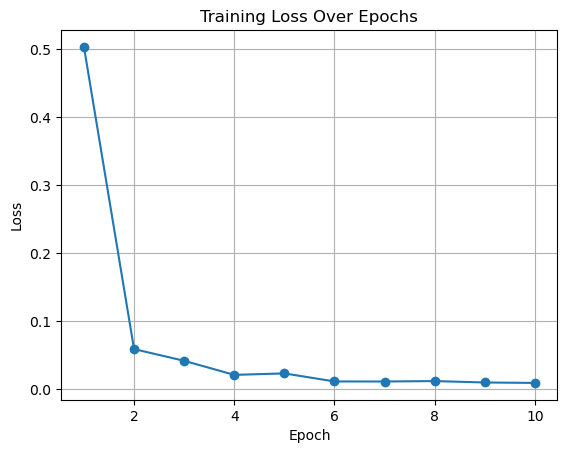

INFO:tensorflow:Assets written to: ./saved_model/saved_notebook_06b/advanced_model\assets


INFO:tensorflow:Assets written to: ./saved_model/saved_notebook_06b/advanced_model\assets


In [16]:
import matplotlib.pyplot as plt

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# Training Loop
epochs = 10
history = LossHistory()

# Latih model
transformer_model.fit(bpe_dataloader, epochs=epochs, callbacks=[history])

# Visualisasi loss selama pelatihan
plt.plot(range(1, epochs + 1), history.losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Simpan model setelah pelatihan
model_path = './saved_model/saved_notebook_06b/advanced_model'
transformer_model.save(model_path)


### Fungsi Prediksi Teks

In [17]:
# Fungsi untuk prediksi teks
def predict_text(model, input_text, token_vocab, inv_token_vocab, max_length=512, gen_length=50):
    input_tokens = [token_vocab.get(c, token_vocab['<unk>']) for c in input_text]
    input_tokens_padded = np.pad(input_tokens, (0, max_length - len(input_tokens)), constant_values=token_vocab['<pad>'])
    input_tokens_padded = tf.expand_dims(input_tokens_padded, 0)  # Tambahkan dimensi batch

    generated_text = input_text

    for _ in range(gen_length):
        predictions = model(input_tokens_padded)
        predictions = predictions[:, len(input_tokens) - 1, :]  # Ambil prediksi dari token terakhir yang valid

        predicted_id = tf.argmax(predictions, axis=-1).numpy()[0]

        print(f"Predicted ID: {predicted_id}, Predicted Token: {inv_token_vocab[predicted_id]}")

        if predicted_id in [token_vocab['<pad>'], token_vocab['<unk>']]:
            break

        input_tokens.append(predicted_id)
        input_tokens_padded = np.pad(input_tokens, (0, max_length - len(input_tokens)), constant_values=token_vocab['<pad>'])
        input_tokens_padded = tf.expand_dims(input_tokens_padded, 0)  # Tambahkan dimensi batch

        generated_text += inv_token_vocab[predicted_id]

        if inv_token_vocab[predicted_id] == '.':
            break

    return generated_text

# Pertanyaan sebagai input
input_question = "Apa yang dimaksud dengan jaringan saraf?"

# Hasilkan teks berdasarkan input
generated_text = predict_text(transformer_model, input_question, token_vocab, inv_token_vocab, max_length=512, gen_length=50)
print("Generated Text:", generated_text)


Predicted ID: 0, Predicted Token: <pad>
Generated Text: Apa yang dimaksud dengan jaringan saraf?
